# Prepare EEG data for training of machine-learning models
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.

## Import packages & links

In [1]:
# Import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))

import mne
#%matplotlib inline
#from mayavi import mlab

In [2]:
from config import ROOT, PATH_CODE, PATH_DATA, PATH_OUTPUT, PATH_METADATA
PATH_CNTS = os.path.join(PATH_DATA, "17mnd mmn")

In [3]:
filename_labels = PATH_METADATA + "Screening_children5a_summary_new.txt" 
metadata = pd.read_csv(filename_labels, sep='\t')
metadata.head()

,id_child,groupDDP,atRiskOrNotDDP,dyslexicAtMidGroup3DDP,assignment1,assignment2,assignment3,assignment4,childInfoPresent,relativeInfoPresent,mmr_2mth,mmr_5mth,mmr_11mth,mmr_17mth,mmr_23mth,mmr_29mth,mmr_35mth,mmr_41mth,mmr_47mth
0,001,4,unclear,1,notEnoughInfo,notEnoughInfo,notEnoughInfo,notEnoughInfo,1,1,1,0,1,1,1,1,1,1,1
1,002,missing,missing,missing,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,0,1,0,0,0,0,1,1,1,0,0
2,003,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,0,1,0,1,1,0
3,004,missing,missing,missing,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,1,1,0,1,1,0,1,0
4,005,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,1,0,1,1,1,0


In [4]:
metadata.shape

(336, 19)

## Search all *.cnt files and check for how many we have a label

In [6]:
import fnmatch
import warnings
warnings.filterwarnings('ignore')

import helper_functions

dirs = os.listdir(PATH_CNTS)
cnt_files = fnmatch.filter(dirs, "*.cnt")

In [7]:
found_ids = [x[:3] for x in cnt_files]
idx = np.where(np.array(found_ids) == '036')[0]
[cnt_files[x] for x in idx]

['036_17_mc_mmn25_wk.cnt', '036_17_mc_mmn36.cnt']

In [8]:
metadata[metadata['id_child'] == '036']['groupDDP'].values[0]

'3Ctrl'

In [9]:
labels = []

found_ids = [x[:3] for x in cnt_files]
for ID in list(set(found_ids)): 
    idx = np.where(np.array(found_ids) == ID)[0]
    filenames = [cnt_files[x] for x in idx]
    label = metadata[metadata['id_child'] == ID]['groupDDP'].values[0]
    label_risk = metadata[metadata['id_child'] == ID]['assignment4'].values[0]
    if label == '1FRdys':
        label = 1
    elif label == '2FRndys':
        label = 0
    elif label == '3Ctrl': #TODO: check if this is correct!
        label = 0
    labels.append([ID, label, label_risk, filenames])

In [10]:
labels[:10]

[['305',
  0,
  'notAtRisk_rest',
  ['305_17_jc_mmn25_wk.cnt', '305_17_jc_mmn36_wk.cnt']],
 ['438',
  1,
  'atRisk',
  ['438_17_jd_mmn_25_slp.cnt',
   '438_17_jd_mmn_25_wk.cnt',
   '438_17_jd_mmn_36_slp.cnt']],
 ['171',
  1,
  'atRisk',
  ['171_17_jr_mmn25_mixed.cnt',
   '171_17_jr_mmn36.cnt',
   '171_17_jr_mmn47_slp.cnt']],
 ['170', 0, 'atRisk', ['170_17_mr_mmn25_wk.cnt', '170_17_mr_mmn_36_wk.cnt']],
 ['749', 1, 'atRisk', ['749-461-17m-jr-mmn36.cnt']],
 ['731',
  1,
  'notEnoughInfo',
  ['731-197-17m-jr-mmn.cnt', '731-197-17m-jr-mmn2.cnt']],
 ['742', 0, 'atRisk', ['742-421-17m-mr-mmn36.cnt']],
 ['139',
  0,
  'notAtRisk_rest',
  ['139_17_mr_mmn25_wk.cnt', '139_17_mr_mmn36_wk.cnt']],
 ['482', 0, 'atRisk', ['482_17_md_mmn25_wk.cnt', '482_17_md_mmn36_wk.cnt']],
 ['154',
  1,
  'notAtRisk_rest',
  ['154_17_jr_mmn25_wk.cnt', '154_17_jr_mmn36_wk.cnt']]]

In [11]:
len(labels), len(list(set(found_ids)))

(247, 247)

### Count number (and type) of labels found:

In [12]:
labels_known = 0
labels_unknown = 0
labels_type = []

for x in labels:
    if x[1] == 1: #'dyslexic'
        labels_known += 1
        labels_type.append(1)
    elif x[1] == 0: #'non-dyslexic'
        labels_known += 1
        labels_type.append(0)
    else: # missing or unclear
        labels_unknown += 1  
        labels_type.append('missing')
        
print("Data with proper labels:", labels_known, "||| Data without proper label:", labels_unknown)     

Data with proper labels: 209 ||| Data without proper label: 38


In [13]:
print("Data for 'dyslexic':", labels_type.count(1))
print("Data for 'non-dyslexic':", labels_type.count(0))

Data for 'dyslexic': 49
Data for 'non-dyslexic': 160


In [14]:
# Check types of risk group labels found
labels_risktype = [x[2] for x in labels]
list(set(labels_risktype))

['atRisk',
 'missing',
 'notAtRisk_highestScores',
 'notEnoughInfo',
 'notAtRisk_rest']

In [15]:
metadata['atRiskOrNotDDP'][:10]

0      unclear
1      missing
2    notAtRisk
3      missing
4    notAtRisk
5    notAtRisk
6    notAtRisk
7    notAtRisk
8    notAtRisk
9      unclear
Name: atRiskOrNotDDP, dtype: object

In [16]:
group_notrisk = np.array(1*((metadata['atRiskOrNotDDP'] == 'notAtRisk')
                   | (metadata['assignment4'].isin(['notAtRisk_rest', 'notAtRisk_highestScores']))))

group_risk = np.array(1*((metadata['atRiskOrNotDDP'] == 'atRisk')
                   | (metadata['assignment4'] == 'at risk')))

In [17]:
np.sum(group_risk) + np.sum(group_notrisk)

307

In [18]:
label_risk = group_notrisk + 2*group_risk 
label_risk[label_risk == 3] = 2
label_risk = label_risk -1

In [19]:
label_risk

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0, -1, -1,  1, -1,  1,  0, -1,  0,  1,  1,  1, -1, -1,  0,  1,
        1,  0,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,
        1,  1,  0,  1,  1,  1,  1,  1,  0, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0, -1, -1,  1,  1, -1,  0, -1,  1,  1,  1,  1,
        1,  1,  0,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  0, -1, -1,  1,  1,  1,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [20]:
group_notdys = np.array(1*(metadata['groupDDP'].isin(['1FRdys', '3Ctrl'])))

group_dys = np.array(1*(metadata['groupDDP'] == '2FRndys'))

In [21]:
np.sum(group_notdys) + np.sum(group_dys)

252

In [22]:
label_dys = group_notdys + 2*group_dys 
label_dys[label_dys == 3] = 2
label_dys = label_dys -1

In [23]:
label_dys

array([-1, -1,  0, -1,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,  0,  0,
        0,  0, -1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  0, -1, -1, -1,  0,
        0, -1,  1,  1,  0,  0,  1,  1, -1,  0,  0,  1,  1, -1, -1,  1, -1,
        0,  1, -1,  1,  1,  0,  1,  0, -1, -1,  0,  1,  1,  0,  1, -1,  1,
        1,  1,  0,  1,  0,  1,  0,  1, -1,  1,  0,  1, -1,  0,  1,  0,  0,
        1,  0, -1,  0,  0, -1,  0,  1,  1,  1,  1,  1,  1,  0,  0, -1, -1,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1,
       -1,  0,  0,  0,  0,  0, -1, -1,  1,  0, -1,  0, -1,  0,  0,  0,  0,
        0,  0, -1,  1,  1,  1,  1, -1, -1, -1,  1,  0,  1, -1,  1,  0,  0,
        1,  1,  0,  1, -1,  1,  0, -1, -1, -1,  1,  0,  1,  0,  1,  0,  1,
        1,  1,  1,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1,  1,  1,  1,  0,
        1,  1,  0,  1,  1

## create Dataframe with labels to be used

In [24]:
labels_final = pd.DataFrame(data=metadata['id_child'].values, columns=['id_child'])
labels_final['label_dys'] = label_dys
labels_final['label_risk'] = label_risk
labels_final.head()

,id_child,label_dys,label_risk
0,001,-1,-1
1,002,-1,0
2,003,0,0
3,004,-1,0
4,005,0,0


In [25]:
print("Data for 'at risk':", labels_risktype.count('atRisk'))
print("Data for 'notAtRisk_rest':", labels_risktype.count('notAtRisk_rest'))
print("Data for 'notAtRisk_highestScores':", labels_risktype.count('notAtRisk_highestScores'))

Data for 'at risk': 91
Data for 'notAtRisk_rest': 56
Data for 'notAtRisk_highestScores': 49


In [26]:
labels_risktype = [x[2] for x in labels if x[1] in [1,0]]
print("Data for 'at risk':", labels_risktype.count('atRisk'))
print("Data for 'notAtRisk_rest':", labels_risktype.count('notAtRisk_rest'))
print("Data for 'notAtRisk_highestScores':", labels_risktype.count('notAtRisk_highestScores'))

Data for 'at risk': 79
Data for 'notAtRisk_rest': 43
Data for 'notAtRisk_highestScores': 45


In [27]:
metadata.loc[(metadata['groupDDP'].isin(['1FRdys', '2FRndys', '3Ctrl']) 
              & metadata['assignment4'].isin(['at risk', 'notAtRisk_rest', 'notAtRisk_highestScores', ]))]

,id_child,groupDDP,atRiskOrNotDDP,dyslexicAtMidGroup3DDP,assignment1,assignment2,assignment3,assignment4,childInfoPresent,relativeInfoPresent,mmr_2mth,mmr_5mth,mmr_11mth,mmr_17mth,mmr_23mth,mmr_29mth,mmr_35mth,mmr_41mth,mmr_47mth
2,003,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,0,1,0,1,1,0
4,005,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,1,0,1,1,1,0
5,006,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,0,1,1,1,0,1,0
8,009,3Ctrl,notAtRisk,1,notEnoughInfo,notEnoughInfo,notEnoughInfo,notAtRisk_rest,1,1,1,0,1,1,1,1,1,1,0
15,016,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,1,1,0,0,0,0,0,0
16,017,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,1,1,0,0,1,0
17,018,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,1,1,1,1,1,0
19,021,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,1,1,1,1,1,0
21,023,3Ctrl,notAtRisk,0,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,notAtRisk_highestScores,1,1,1,0,1,0,1,1,1,1,0
22,024,3Ctrl,notAtRisk,0,notAtRisk_rest,notAtRisk_rest,notAtRisk_rest,notAtRisk_rest,1,1,1,0,1,0,1,1,0,1,0


## Custom cnt-file import function:

In [31]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [3, 13, 66],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = np.zeros((0))
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    #events = mne.find_events(data_raw, shortest_event=0, stim_channel='STI 014', verbose=False)
    
    # TODO: check here already if event_idx's in event_dict
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]#, 'STI 014']]
    
    for event_id in event_idx:
        if str(event_id) in epochs.event_id:
            # Pick EEG channels 
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict, 
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 
                                                                          event_id, 
                                                                          threshold = threshold, 
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            if len(bad_channels) > 0: 
                # Mark bad channels:
                data_raw.info['bads'] = bad_channels
                # Pick EEG channels:
                picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                   #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])
                epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict, 
                                    tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                    baseline=baseline, preload=True, verbose=False)
                # Interpolate bad channels using functionality of 'mne'
                epochs.interpolate_bads()

            # Get signals as array and add to total collection
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            #label_collection = np.concatenate((label_collection, event_id*label_group*np.ones((signals_cleaned.shape[0]))), axis=0)
            label_collection = [str(event_id) + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection#.astype(int)

In [30]:
found_ids = [x[:3] for x in cnt_files]
idx = np.where(np.array(found_ids) == '036')[0]
[cnt_files[x] for x in idx]

['036_17_mc_mmn25_wk.cnt', '036_17_mc_mmn36.cnt']

In [141]:
filename = os.path.join(PATH_DATA_01, '007_17_jc_mmn.cnt')#'035_17_jc_mmn25.cnt')
data_raw = mne.io.read_raw_cnt(filename, eog=['HEOG', 'VEOG'], preload=True) #, montage=None, eog='auto', preload=True)
#data_raw.filter(0.5, 40, fir_design='firwin')

ValueError: not enough values to unpack (expected 2, got 0)

In [139]:
data_raw.info #.get_data().shape

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, ...
    chs : list | 64 items (EEG: 62, EOG: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    subject_info : dict | 5 items
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : No

In [140]:
events_from_annot, event_dict = mne.events_from_annotations(data_raw)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['0', '14', '15', '4', '5', '77', '88']
{'0': 1, '14': 2, '15': 3, '4': 4, '5': 5, '77': 6, '88': 7}
[[6663    0    4]
 [7388    0    4]
 [8115    0    4]
 [8840    0    4]
 [9566    0    2]]


(500, 3)


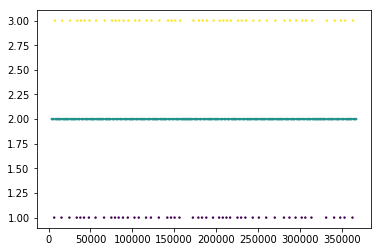

In [132]:
from matplotlib import pyplot as plt
print(events_from_annot.shape)

plt.scatter(events_from_annot[:,0], events_from_annot[:,2], s=2, c = events_from_annot[:,2])


In [126]:
# channel names for 62 EEG channel case: 
print(epochs.ch_names)

['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']


## Check how many EEG channels the cnt-files feature... 

In [142]:
format_collection = []
for i, filename in enumerate(cnt_files):
    # Import file 
    file = os.path.join(PATH_CNTS, filename)
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)
        format_collection.append((i, len(data_raw.ch_names)))
        print(i, len(data_raw.ch_names))
    except ValueError:
        print("ValueError for file:", filename)
        format_collection.append((i, 0))

Reading 0 ... 1500919  =      0.000 ...  3001.838 secs...
0 64
Reading 0 ... 1120199  =      0.000 ...  2240.398 secs...
1 64
Reading 0 ... 1481999  =      0.000 ...  2963.998 secs...
2 64
ValueError for file: 007_17_jc_mmn.cnt
Reading 0 ... 618439  =      0.000 ...  1236.878 secs...
4 64
Reading 0 ... 449859  =      0.000 ...   899.718 secs...
5 64
Reading 0 ... 1868319  =      0.000 ...  3736.638 secs...
6 64
Reading 0 ... 781299  =      0.000 ...  1562.598 secs...
7 64
Reading 0 ... 1872419  =      0.000 ...  3744.838 secs...
8 64
Reading 0 ... 369239  =      0.000 ...   738.478 secs...
9 64
Reading 0 ... 370279  =      0.000 ...   740.558 secs...
10 64
Reading 0 ... 369359  =      0.000 ...   738.718 secs...
11 64
Reading 0 ... 368939  =      0.000 ...   737.878 secs...
12 64
Reading 0 ... 375739  =      0.000 ...   751.478 secs...
13 64
Reading 0 ... 377639  =      0.000 ...   755.278 secs...
14 64
Reading 0 ... 256699  =      0.000 ...   513.398 secs...
15 64
Reading 0 ... 379099

KeyboardInterrupt: 

In [144]:
a,b = zip(*format_collection)
len(np.where((np.array(b) == 64))[0]), len(np.where((np.array(b) == 32))[0]), len(a)

(86, 0, 86)

So far we 'only' have about 60 cnt-files of which we have a label ("risk group" vs "no risc group").
And only 42 of them feature 62 EEG channels. I hence switched to 30 EEG channels and picked the ones that are present in all patient datasets.

# Workflow data processing
1. Load cnt files.
2. Select same number of channels (here: 30 same channels which exist for both 30 and 62 channel data)
3. Preprocess raw data (bandpass + detect outliers and 'bad' epochs).
4. Store epoch data and event type as array

## LABELS:
+ After Karin's search we have proper labels for much more files!  


In [32]:
# Initialize array
signal_collection = np.zeros((0,30,501)) #62
label_collection = np.zeros((0))
metadata_collection = []

for i, filename in enumerate(cnt_files[:5]):
    
    # First check if we have proper label for that file
    # -----------------------------------------------------------
    
    ID = filename[:3]
    label = labels_final[labels_final['id_child'] == ID]['label_dys'].values[0]
    label_risk = labels_final[labels_final['id_child'] == ID]['label_risk'].values[0]
    #label = metadata[metadata['id_child'] == ID]['groupDDP'].values[0]
    #label_risk = metadata[metadata['id_child'] == ID]['assignment4'].values[0]
    
    if (label < 0) or (label_risk < 0):
        print("No proper label found for file: ", filename)
    else:
        #label_group = int(metadata[metadata["file"].str.match(filename[:-4])]['group'])
        label_group = 'dys' + str(label) + '_risk' + str(label_risk)
        
        print(40*"=")
        print("Importing file: ",filename)
        print("Data belongs into group: ", label_group)

        # Import data and events
        file = os.path.join(PATH_CNTS, filename)

        signal_collect, label_collect = read_cnt_file(file, 
                                                      label_group,
                                                      event_idx = [3, 13, 66],
                                                      channel_set = "30",
                                                      tmin = -0.2,
                                                      tmax = 0.8,
                                                      lpass = 0.5, 
                                                      hpass = 40, 
                                                      threshold = 5, 
                                                      max_bad_fraction = 0.2)
        
        if signal_collect is not None:
            # Get signals as array and add to total collection
            signal_collection = np.concatenate((signal_collection, signal_collect), axis=0)
            label_collection = np.concatenate((label_collection, label_collect), axis=0)
            metadata_collection.append((i, filename, signal_collection.shape[0]))


No proper label found for file:  001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp.cnt
Importing file:  005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed.cnt
Data belongs into group:  dys0_risk0
Reading 0 ... 1120199  =      0.000 ...  2240.398 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '13', '14', '2', '3', '4', '55', '66', '77']
No outliers found with given threshold.
No outliers found with given threshold.
No outliers found wit

In [34]:
signal_collection.shape, signal_collect.shape

((993, 30, 501), (0, 30, 501))

In [35]:
signal_collection.shape, label_collection.shape

((993, 30, 501), (100,))

In [36]:
metadata_collection[:10]

[(1, '005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed.cnt', 500),
 (2, '006_17_mc_mmn36_slp.cnt', 993),
 (4, '007_17_jc_mmn2.cnt', 993)]

In [38]:
label_collection[:10]

array(['66dys0_risk0', '66dys0_risk0', '66dys0_risk0', '66dys0_risk0',
       '66dys0_risk0', '66dys0_risk0', '66dys0_risk0', '66dys0_risk0',
       '66dys0_risk0', '66dys0_risk0'], dtype='<U32')

We hence get a dataset of 39083 datapoints with known label.  
Each datapoint consits of a 1-second EEG signal of 30 channels with a 500Hz sampling rate. Thus arrays with a size of 30 x 501. 

## Labels 
Here we have 6 labels. 
1. Group 1, stimuli 3 --> "3"
2. Group 1, stimuli 13 --> "13"
3. Group 1, stimuli 66 --> "66"
4. Group 2, stimuli 3 --> "6"
5. Group 2, stimuli 13 --> "26"
6. Group 2, stimuli 66 --> "132"

In [41]:
label_collection[1500:2000].astype(int)

array([  6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   

# Save entire processed dataset:

In [75]:
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected.npy"
np.save(filename, signal_collection)

filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_labels.npy"
np.save(filename, label_collection)

import csv
filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_metadata.csv"

with open(filename, 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(metadata_collection)
csvFile.close()